In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-11-20 08:37:13.755746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 08:37:13.861219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-20 08:37:13.861259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 08:37:13.874496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-20 08:37:13.905250: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## Try advecting noise from Lagrangian to Eulerian space

### Generate a noise field with a random normal distribution

In [3]:
nbar_fid = 0.00022

def gen_noise_field(nbar_fid, n_grid, box_size, seed):
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar_fid * cell_volume)

    rng = np.random.default_rng(seed=seed)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    return noise_field

In [4]:
n_grid_orig = 512
n_grid_target = 128
box_size = 1000.0

In [5]:
noise_field_hires = gen_noise_field(nbar_fid, n_grid_orig, box_size, 0)
noise_field_hires.shape

(512, 512, 512)

### Load in muchisimocks displacements and construct particle positions

This is for LH0, a particular cosmology that doesn't necessarily match the mock we are trying to model. It's one I happen to have the displacements saved (hence the "rerun" in the path).

In [6]:
dir_mocks = '/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000_rerun'
subdir_prefix = 'LH'
idx_mock = 0
dir_LH = f'{dir_mocks}/{subdir_prefix}{idx_mock}'
fn_disp = f'{dir_LH}/pred_disp.npy'

In [7]:
pred_disp = np.load(fn_disp, allow_pickle=True)
print(pred_disp.shape)

(3, 512, 512, 512)


In [8]:
## Create regular grid and displace particles
print("Generating grid", flush=True)
grid = bacco.visualization.uniform_grid(npix=n_grid_orig, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements", flush=True)
pred_pos = bacco.scaler.add_displacement(None,
                                pred_disp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=True)[0]
print(pred_pos.shape)

Generating grid
Adding predicted displacements


2025-11-20 08:37:25,301 bacco.scaler : Adding displacement field with a vel-factor=0.000000


(134217728, 3)


### Advect noise field to Eulerian space

In [9]:
noise_field_eul_hires = bacco.statistics.compute_mesh(ngrid=n_grid_orig, box=box_size, pos=pred_pos, 
                                mass = (noise_field_hires).flatten(), deposit_method='cic', 
                                interlacing=False)
noise_field_eul_hires = np.squeeze(noise_field_eul_hires)

2025-11-20 08:37:27,778 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-11-20 08:37:27,965 bacco.statistics : starting deposit 1
2025-11-20 08:37:30,133 bacco.statistics :  mesh done in 2.35 s


In [10]:
noise_field_eul = utils.remove_highk_modes(noise_field_eul_hires, box_size, n_grid_target)
print(noise_field_eul.shape)

(128, 128, 128)


In [11]:
noise_field_hires_kcut = utils.remove_highk_modes(noise_field_hires, box_size, n_grid_target)
print(noise_field_hires_kcut.shape)

(128, 128, 128)


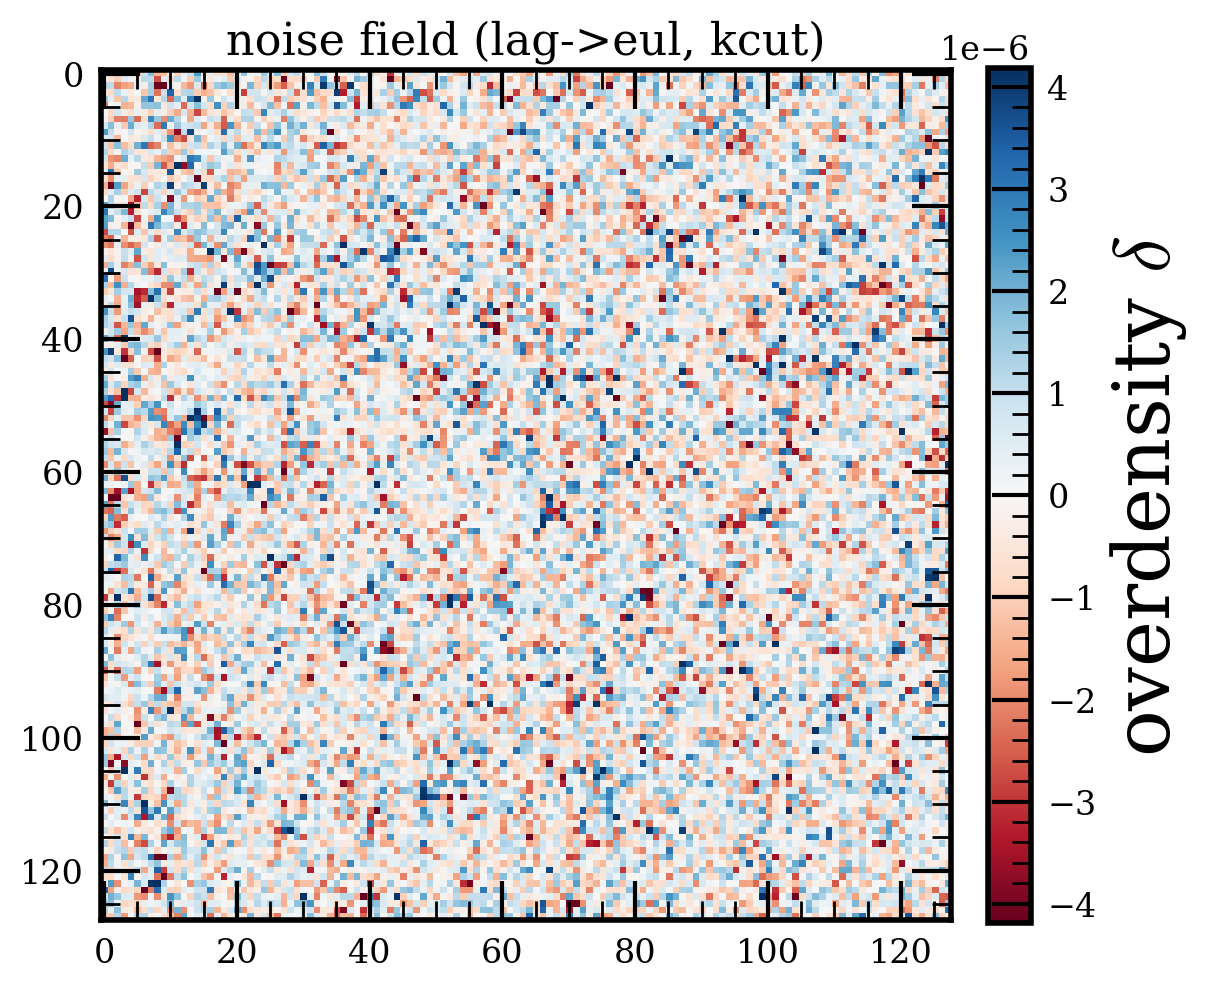

In [12]:
plotter.plot_overdensity_field(noise_field_eul, title='noise field (lag->eul, kcut)')

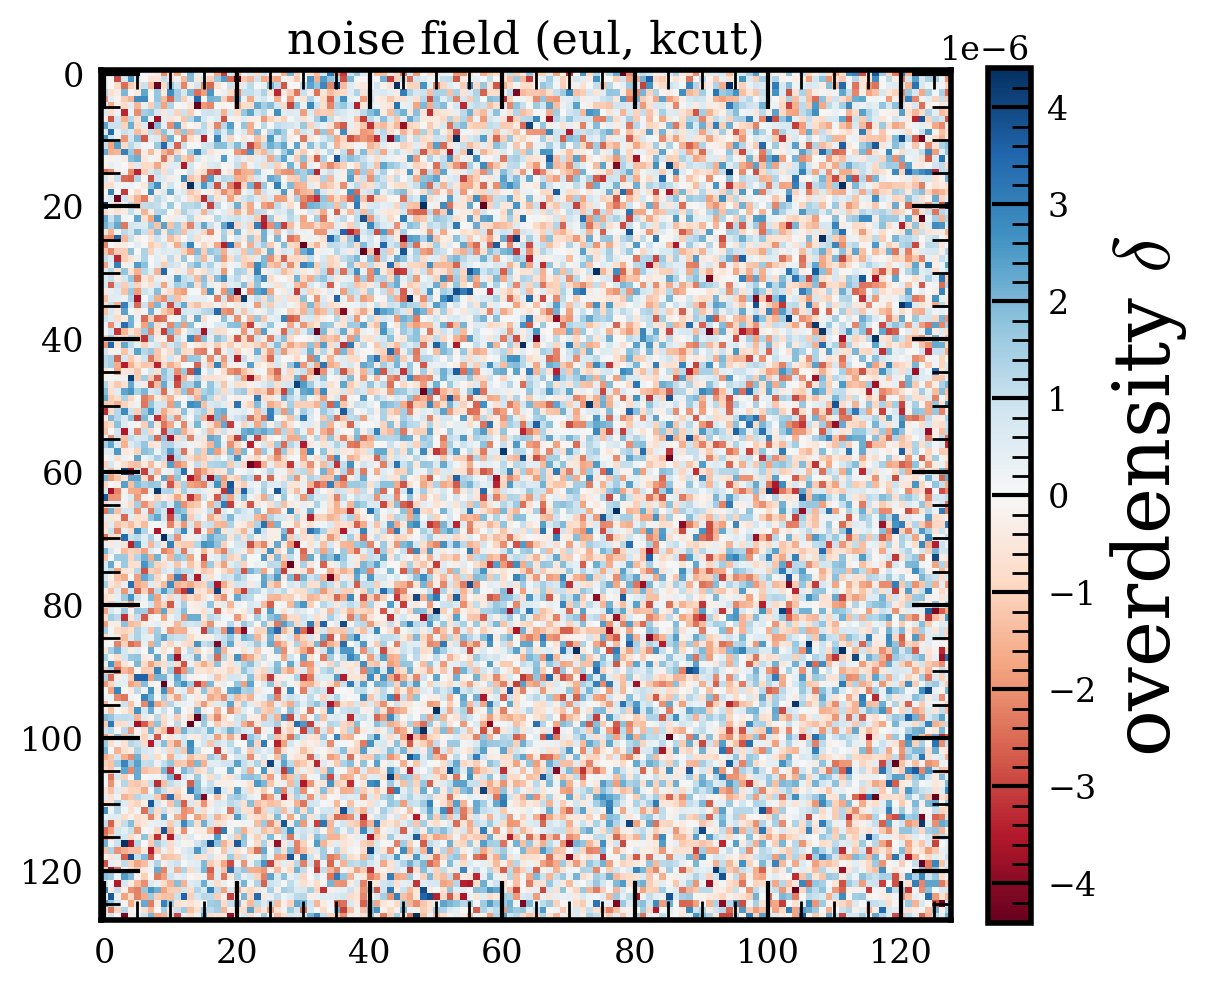

In [13]:
plotter.plot_overdensity_field(noise_field_hires_kcut, title='noise field (eul, kcut)')

### Compute power spectra and bispectra

In [14]:
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [15]:
pk_obj_noise = cs.compute_pk(noise_field_hires_kcut, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-20 08:37:37,611 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2025-11-20 08:37:39,310 bacco.statistics :  ...done in 1.7 s


In [16]:
pk_obj_noiseeul = cs.compute_pk(noise_field_eul, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  128


2025-11-20 08:37:39,729 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-20 08:37:39,798 bacco.statistics :  ...done in 0.0689 s


In [17]:
pk_obj_noise_hires = cs.compute_pk(noise_field_hires, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  512


2025-11-20 08:37:40,162 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


2025-11-20 08:37:46,038 bacco.statistics :  ...done in 5.88 s


In [18]:
pk_obj_noiseeul_hires = cs.compute_pk(noise_field_eul_hires, cosmo, box_size,
                        n_threads=1)

Computing pk, using n_grid =  512


2025-11-20 08:37:46,486 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2025-11-20 08:37:51,640 bacco.statistics :  ...done in 5.15 s


In [19]:
base = cs.setup_bispsec(box_size, n_grid_target, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.21 s


In [20]:
bspec_noise, bk_corr_noise = cs.compute_bispectrum(base, noise_field_hires_kcut)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [21]:
bspec_noiseeul, bk_corr_noiseeul = cs.compute_bispectrum(base, noise_field_eul)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [22]:
base_hires = cs.setup_bispsec(box_size, n_grid_orig, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [512, 512, 512]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [1.608, 1.608, 1.608] h/Mpc
# Pixel window: none


# Using fftw backend
PolyBin3D setup time: 14.12 s


In [23]:
# these crash my kernel, leave out for now
# bspec_noise_hires, bk_corr_noise_hires= cs.compute_bispectrum(base_hires, noise_field_hires)

In [24]:
#bspec_noiseeul_hires, bk_corr_noiseeul_hires= cs.compute_bispectrum(base_hires, noise_field_eul_hires)

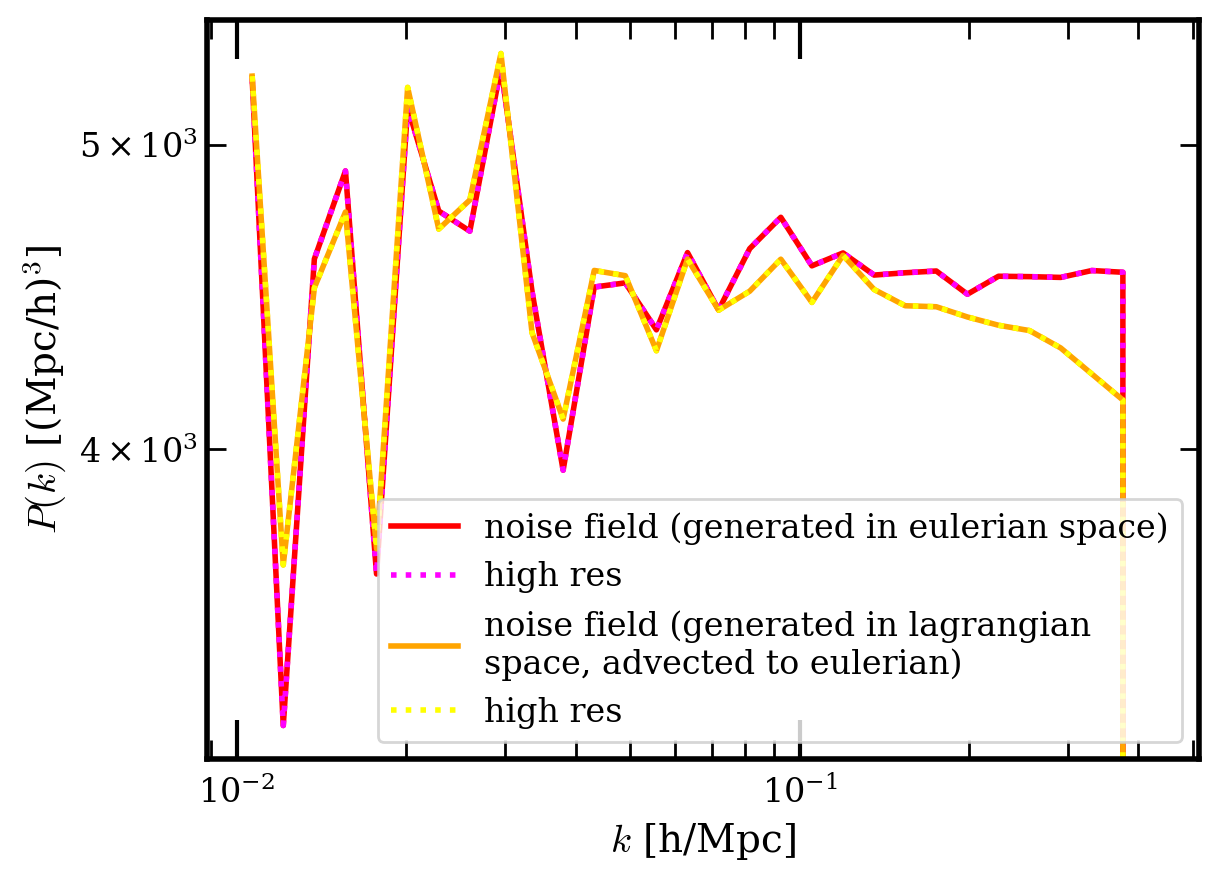

In [25]:
plt.plot(pk_obj_noise['k'], pk_obj_noise['pk'], color='red', ls='-', label='noise field (generated in eulerian space)', lw=2)
plt.plot(pk_obj_noise_hires['k'], pk_obj_noise_hires['pk'], color='magenta', ls=':', label='high res', lw=2)
plt.plot(pk_obj_noiseeul['k'], pk_obj_noiseeul['pk'], color='orange', ls='-', label='noise field (generated in lagrangian\nspace, advected to eulerian)', lw=2)
plt.plot(pk_obj_noiseeul_hires['k'], pk_obj_noiseeul_hires['pk'], color='yellow', ls=':', label='high res', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=12)

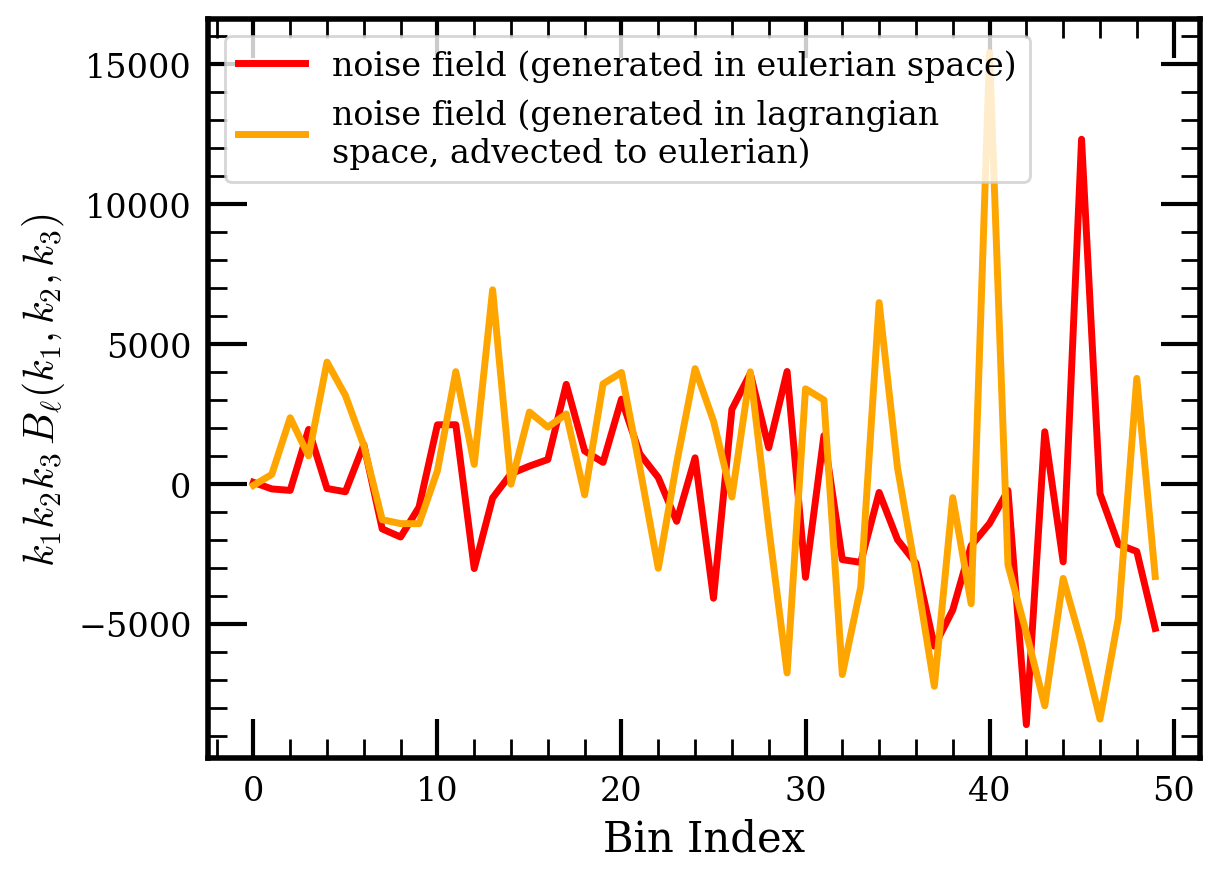

In [26]:
k123 = bspec_noiseeul.get_ks()
weight = k123.prod(axis=0)

norm = n_grid_target**3

plt.plot(norm**3 * weight*bk_corr_noise['b0'], color='red', ls='-', label='noise field (generated in eulerian space)')
#plt.plot(norm**3 * weight*bk_corr_noise_hires['b0'], color='magenta', ls=':', label='high res (eulerian)')
plt.plot(norm**3 * weight*bk_corr_noiseeul['b0'], color='orange', ls='-', label='noise field (generated in lagrangian\nspace, advected to eulerian)')
#plt.plot(norm**3 * weight*bk_corr_noiseeul_hires['b0'], color='yellow', ls=':', label='high res (lagrangian)')


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)